In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pillow!=8.3.*,>=5.3.0 in c:\users\katda\anaconda3\lib\site-packages (from torchvision) (9.0.1)



In [192]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [199]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [200]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [201]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),

])

val_dataset = torchvision.datasets.DatasetFolder("rsna-pneumonia-detection-challenge/Processed/val", loader=load_file, extensions="npy", transform=val_transforms)

In [218]:
tempmodel = torchvision.models.resnet50()
print(tempmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [204]:
from torch import nn
import torchvision
from pathlib import Path
MODEL_PATH = Path("models/")
MODEL_NAME = "posweight3lr0001_resnet50with_100_Percent_Training_Images_30_epochs.pth"
# 2. Create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Create a ResNet50 model.
loaded_model = torchvision.models.resnet50(pretrained=False)
loaded_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
loaded_model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH,map_location=device))


# Set the model to evaluation mode.
loaded_model.eval()
loaded_model.to(device);

cpu


In [205]:
class PneumoniaModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = loaded_model
        # Change conv1 from 3 to 1 input channels
        #self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet50) from 1000 to 1
        #self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Flatten the output into a 2048 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        #print(avg_pool_output_flattened.shape)
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        #pred = self.model(data)
        return pred, feature_map
    

In [206]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((2048, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)


In [207]:
cammodel = PneumoniaModel()
cammodel.eval();

In [221]:
img = val_dataset[-9][0]
img.shape

torch.Size([1, 224, 224])

In [222]:
img , label= val_dataset[-9]  # Select a subject
# Compute the Class activation map given the subject
activation_map, pred = cam(cammodel, img)
pred2 = torch.sigmoid(loaded_model(img.unsqueeze(1))[0].cpu())
print(label)
print(pred)
print(pred2)


torch.Size([1, 2048, 1, 1])
1
tensor([0.8726])
tensor([0.8726], grad_fn=<SigmoidBackward0>)


<IPython.core.display.Javascript object>


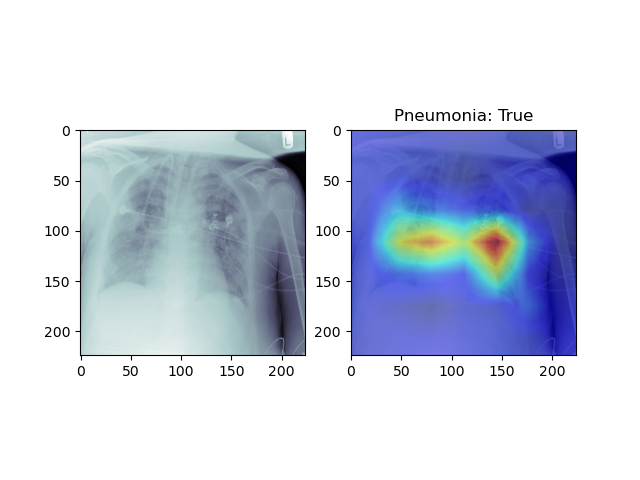

Text(0.5, 1.0, 'Pneumonia: True')

In [223]:
%matplotlib notebook

img1 = img[0]
# Resize the activation map of size 7x7 to the original image size (224x224)
heatmap = transforms.functional.resize(
    activation_map.unsqueeze(0), (224, 224))[0]

# Create a figure
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1, cmap="bone")
# Overlay the original image with the upscaled class activation map

axis[1].imshow(img1, cmap="bone")
axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
plt.title(f"Pneumonia: {(pred[0] > 0.5).item()}")
